In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


In [ ]:
# Walmart Recruiting - Store Sales Forecasting
# Use historical markdown data to predict store sales

# 1. train,test set 불러오기

In [2]:
pd.options.display.max_columns = 100

train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip", parse_dates = ["Date"])
test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip", parse_dates = ["Date"])

display(train.head(),test.head())

# ------------------추가사항----------------------

# 이상치(outlier) 처리하기
train = train[train["Weekly_Sales"] > -1100 ]
train = train[train["Weekly_Sales"] < 600000]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False



# 2. train set과 test set을 alldata로 묶어 data set의 전처리를 한번에 적용
-  문자열이 섞여있는 "Date" column을 새롭게 파싱
-  필요없는 columns 제거 ex)정답값

In [3]:
alldata = pd.concat([train,test])

# 날짜 Parsing
alldata["year"] = alldata["Date"].dt.year
alldata["month"] = alldata["Date"].dt.month
alldata["day"] = alldata["Date"].dt.day
alldata["week"] = alldata["Date"].dt.week

alldata

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day,week
0,1,1,2010-02-05,24924.50,False,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,2010,3,5,9
...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,NaN,False,2013,6,28,26
115060,45,98,2013-07-05,NaN,False,2013,7,5,27
115061,45,98,2013-07-12,NaN,False,2013,7,12,28
115062,45,98,2013-07-19,NaN,False,2013,7,19,29


# 3. 통계량 추가하기

> 통계량 정보를 추가를 하였으나 
1. 정답값과의 상관관계는 0.02이하로 매우 연관성이 낮고
2. 모델의 학습변수중요도를 확인한 후, 점수에 주는 영향이 없어서 주석처리 함 

In [4]:
# s_sale = alldata.groupby("Store")["Weekly_Sales"].agg(["mean","max","count"]).reset_index()
# s_sale = s_sale.rename(columns = {"mean":"s_mean","max":"s_max","count":"s_count"})
# alldata = pd.merge(alldata,s_sale,on="Store")

# d_sale = alldata.groupby("Dept")["Weekly_Sales"].agg(["mean","max","count"])
# d_sale = d_sale.rename(columns = {"mean":"d_mean","max":"d_max","count":"d_count"})
# alldata = pd.merge(alldata,d_sale,on="Dept")

# h_sale = alldata.groupby("IsHoliday")["Weekly_Sales"].agg(["mean","max","count"])
# h_sale = h_sale.rename(columns = {"mean":"h_mean","max":"h_max","count":"h_count"})
# alldata = pd.merge(alldata,h_sale,on="IsHoliday")

# y_sale = alldata.groupby("year")["Weekly_Sales"].agg(["mean","max","count"])
# y_sale = y_sale.rename(columns = {"mean":"y_mean","max":"y_max","count":"y_count"})
# alldata = pd.merge(alldata,y_sale,on="year")

# w_sale = alldata.groupby("month")["Weekly_Sales"].agg(["mean","max","count"])
# w_sale = w_sale.rename(columns = {"mean":"w_mean","max":"w_max","count":"w_count"})
# alldata = pd.merge(alldata,w_sale,on="month")

# alldata.corr()["Weekly_Sales"].sort_values(ascending = False)

In [5]:
alldata2 = alldata.drop(["Date","Weekly_Sales"],axis = 1)
alldata2.head()

,Store,Dept,IsHoliday,year,month,day,week
0,1,1,False,2010,2,5,5
1,1,1,True,2010,2,12,6
2,1,1,False,2010,2,19,7
3,1,1,False,2010,2,26,8
4,1,1,False,2010,3,5,9


# 4. 새로운 정보를 추가하기 위해 다른 파일 불러오기

1. feature.csv
> 각 Store의 날짜별 온도,연료값...등의 정보

2. store.csv
>  각 Store 별 type와 size의 정보

In [6]:
# 1.feature.csv

feature = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip")
feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
feature[feature["Date"]=="2010-02-05"]
# - 각각의 1부터 45의 Store 별로 하루치의 정보가 있음을 알 수 있다.

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
182,2,2010-02-05,40.19,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False
364,3,2010-02-05,45.71,2.572,NaN,NaN,NaN,NaN,NaN,214.424881,7.368,False
546,4,2010-02-05,43.76,2.598,NaN,NaN,NaN,NaN,NaN,126.442065,8.623,False
728,5,2010-02-05,39.70,2.572,NaN,NaN,NaN,NaN,NaN,211.653972,6.566,False
910,6,2010-02-05,40.43,2.572,NaN,NaN,NaN,NaN,NaN,212.622352,7.259,False
1092,7,2010-02-05,10.53,2.580,NaN,NaN,NaN,NaN,NaN,189.381697,9.014,False
1274,8,2010-02-05,34.14,2.572,NaN,NaN,NaN,NaN,NaN,214.471451,6.299,False
1456,9,2010-02-05,38.01,2.572,NaN,NaN,NaN,NaN,NaN,214.655459,6.415,False
1638,10,2010-02-05,54.34,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,9.765,False


- feature.csv로부터 각 Store별 온도,연료값 등의 평균을 대표로 넣었으나
>  위의 통계량과 마찬가지로 정답값과의 상관관계가 낮고 모델에서 걸러져서 주석처리 함


In [8]:
# avg_temp = feature.groupby("Date")["Temperature"].mean().reset_index()
# avg_Fprice = feature.groupby("Date")["Fuel_Price"].mean().reset_index()

# alldata = pd.merge(alldata,avg_temp,on="Date", how="left")  
# alldata = pd.merge(alldata,avg_Fprice, on="Date",how="left")

# avg_feature = feature.drop(["IsHoliday","Store"],axis=1).groupby("Date").mean().reset_index()

# train = pd.merge(train,avg_feature,on="Date")

# train.corr()["Weekly_Sales"]
# train.head()

In [9]:
# 2.store.csv

store = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


- "Type"column은 store["Type"].unique()의 결과 A,B,C 3종류가 있으나, 
- 모델에 학습시키기 위해 RabelEncoding을 이용해 문자열 카테고리에서 숫자형 카테고리column으로 바꿈 (A,B,C -> 0,1,2 )

In [10]:
alldata2 = pd.merge(alldata2,store,on="Store",how="left")

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

alldata2["Type"] = le.fit_transform(alldata2["Type"])
alldata2

,Store,Dept,IsHoliday,year,month,day,week,Type,Size
0,1,1,False,2010,2,5,5,0,151315
1,1,1,True,2010,2,12,6,0,151315
2,1,1,False,2010,2,19,7,0,151315
3,1,1,False,2010,2,26,8,0,151315
4,1,1,False,2010,3,5,9,0,151315
...,...,...,...,...,...,...,...,...,...
536620,45,98,False,2013,6,28,26,1,118221
536621,45,98,False,2013,7,5,27,1,118221
536622,45,98,False,2013,7,12,28,1,118221
536623,45,98,False,2013,7,19,29,1,118221


# 학습을 위해 alldata를 다시 train과 test set으로 분리

In [11]:
train2 = alldata2[:len(train)]
test2 = alldata2[len(train):]

# 5. 시각화

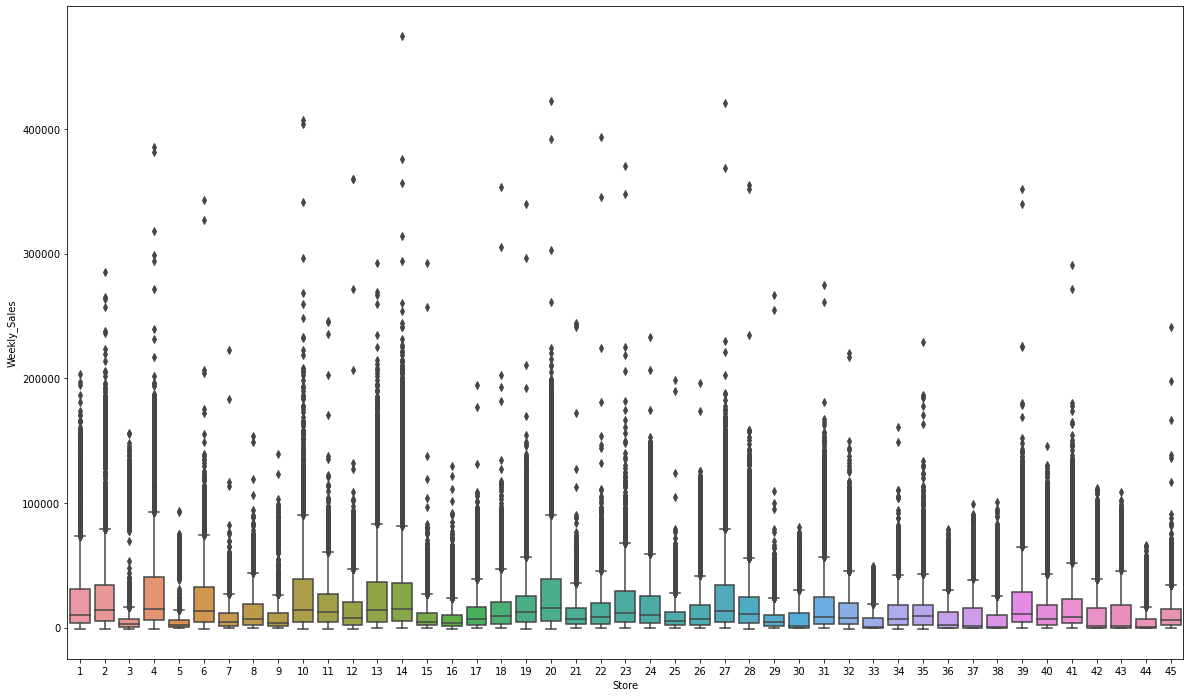

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 각 지점 별 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train["Store"],train["Weekly_Sales"])

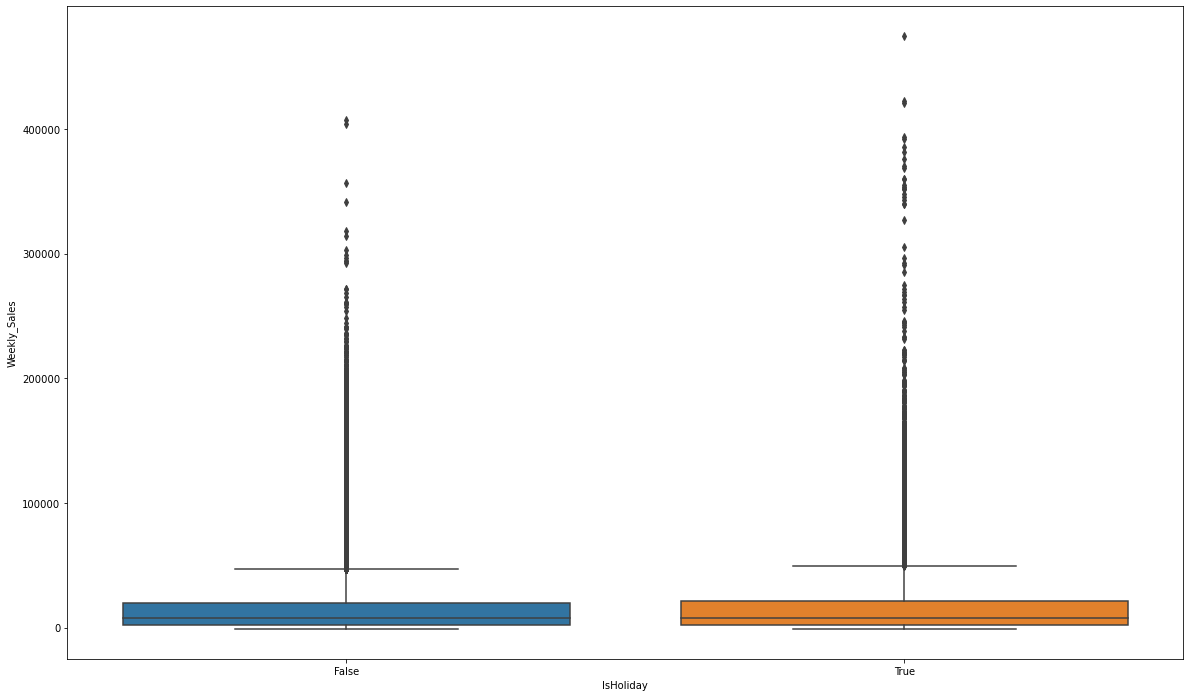

In [13]:
# 휴일의 유무에 따른 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train["IsHoliday"],train["Weekly_Sales"])

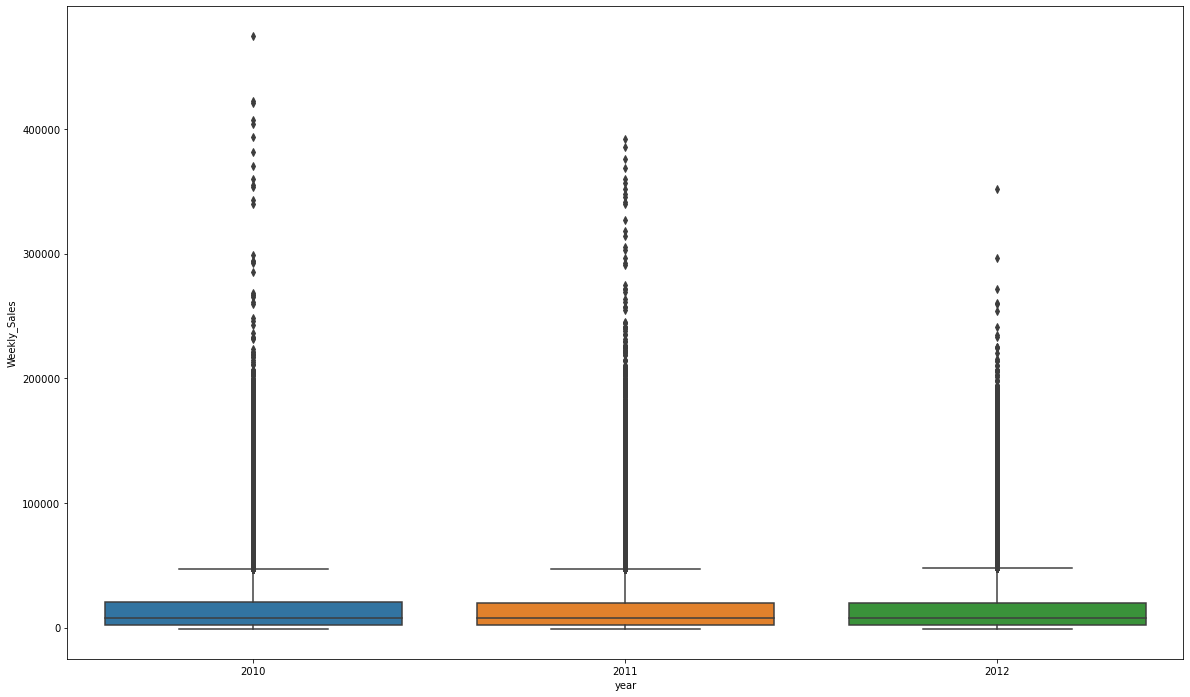

In [14]:
# 연도에 따른 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train2["year"],train["Weekly_Sales"])

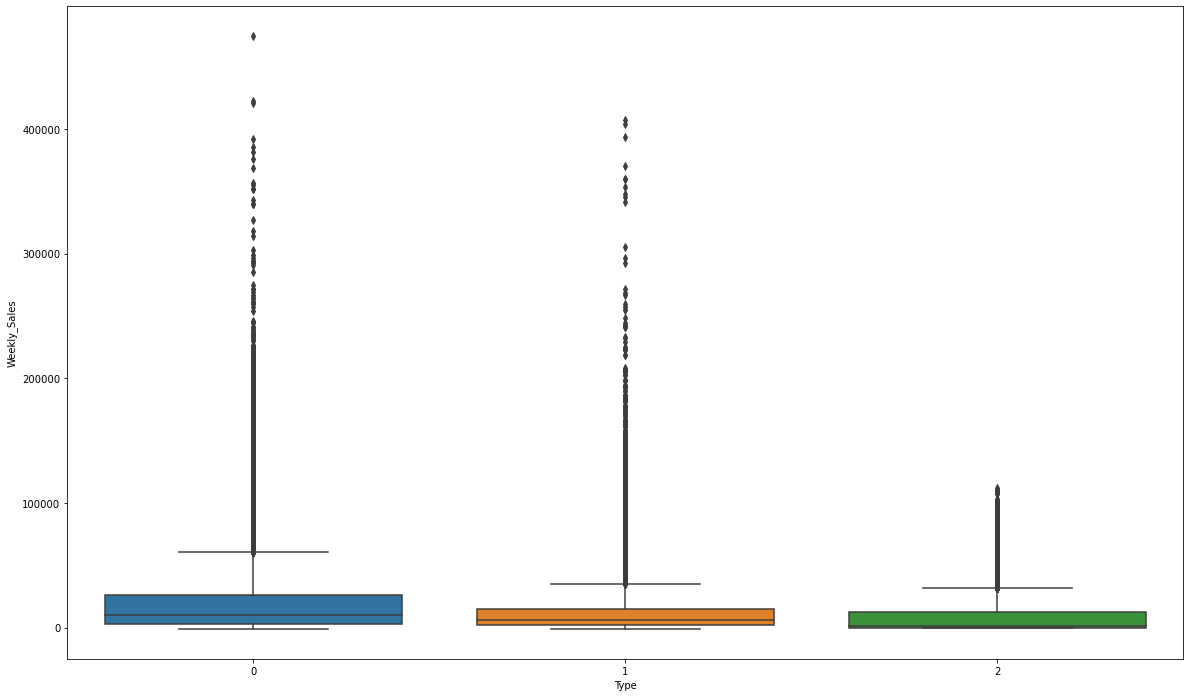

In [15]:
# 지점의 Type에 따른 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train2["Type"],train["Weekly_Sales"])

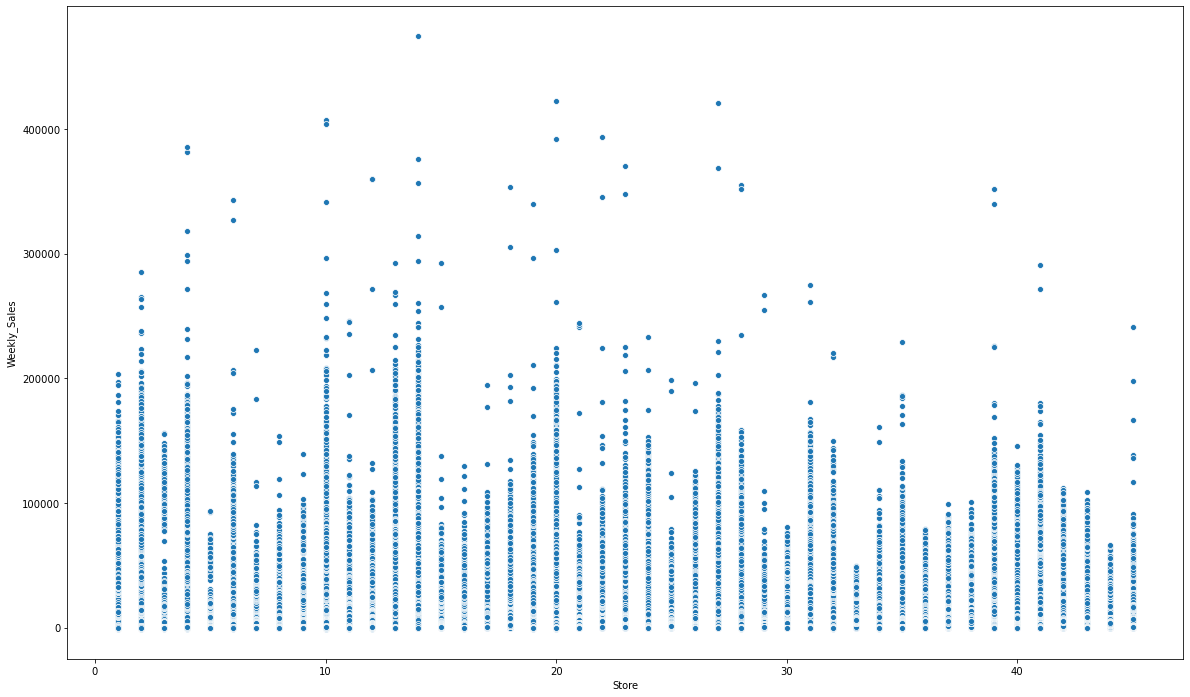

In [16]:
# 지점에 따른 판매량
plt.figure(figsize=(20,12))
sns.scatterplot(train2["Store"],train["Weekly_Sales"])

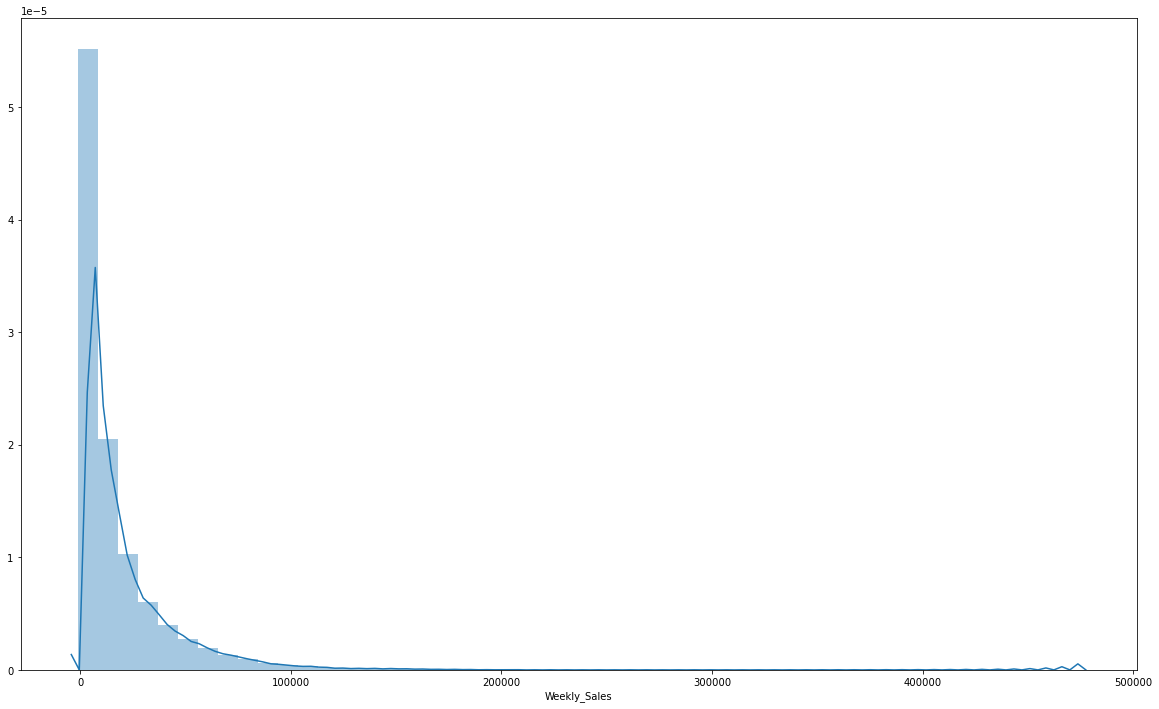

In [17]:
# 판매량의 분포
plt.figure(figsize=(20,12))
sns.distplot(train["Weekly_Sales"])

# 1. (-)값 확인가능, 이상치 처리필요
# 2. 판매량이 낮은 쪽으로 편향되어 결과값에 영향을 줄 수 있다 -> log로 처리해 분산시키기

In [18]:
train["Weekly_Sales"].sort_values()

16297      -1098.00
16295      -1098.00
16291      -1098.00
24830      -1008.96
35561       -898.00
            ...    
95377     404245.03
88428     406988.63
264390    420586.57
195088    422306.25
135665    474330.10
Name: Weekly_Sales, Length: 421561, dtype: float64

# 6. 이상치(Outlie) 및 결측치(Missing Value) 처리
- 위의 plot들과 Weekly_Sales를 정렬한 것에 따르면
1. Weekly_Sales의 -1098의 일반적인 환불로 인한 최대 마이너스 제외, 더 큰 마이너스값들은 제거 후 +1100해서 (-)값 처리
2. 동시에 60만 이상의 Weekly_Sales(4건)은 일반적으로 극히 드문 경우이므로 제거 (train set불러오면서 처리)


In [19]:
# 나머지 결측치는 -1로 치환함
train2 = train2.fillna(-1)
test2 = test2.fillna(-1)

# 7. 머신러닝 모델 설계
- Bagging방식의 RandomForest model를 통해 baseline을 잡고
- 이후 boosting model로 오차 줄이기

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 300, n_jobs = 9, random_state = 1)
rf.fit(train2,np.log(train["Weekly_Sales"]+1100))
result1 = rf.predict(test2)

from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators = 8000, num_leaves = 700)
lgb.fit(train2,np.log(train["Weekly_Sales"]+1100))
result2 = lgb.predict(test2)

# from catboost import CatBoostRegressor
# cat = CatBoostRegressor(n_estimators = 7000,task_type = "GPU", max_depth = 13)
# cat.fit(train2,np.log(train["Weekly_Sales"]+1100))
# result = cat.predict(test2)



# 여러 시행착오 결과, 최종 앙상블은 RandomForest와 LGB 모델로 결정

In [21]:
# 학습변수 중요도
pd.Series(lgb.feature_importances_, index = train2.columns).sort_values(ascending = False)

Dept         1874913
Store         909702
day           846157
Size          576800
week          439806
month         436016
year          399318
Type           72000
IsHoliday      37288
dtype: int32

In [22]:
sub = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip")
sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [23]:
sub["Weekly_Sales"] = (np.exp(result1)-1100)*0.55 + (np.exp(result2)-1100)*0.45
sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,33485.070401
1,1_1_2012-11-09,21582.025417
2,1_1_2012-11-16,19514.173048
3,1_1_2012-11-23,20013.294635
4,1_1_2012-11-30,24508.069098


In [24]:
sub.to_csv("sub.csv", index=False)

# 제출 점수 
- private : 2632.00134
- public : 2577.65277